# Simulation rate estimator

In order to synchronise sound reproduction with the host audio playback pipeline, the rate at which the Atari2600 cycles are simulated must be measured (as it can differ from the ideal value equal to the Atari2600 clolor clock).

The simulation rate is estimated by the `TIASound::resample` functinon. This function assumes to be called at regular intervals to fill the host audio buffer. Under this assumption, it can measure the simulation rate by checking how much the simulation has advanced between calls. The simulation time is obtained by inspecting the latest value of the `cycle` counter registered in the `TIASound` audio buffer, which is in fact close to the last cycle actually simulated. However, `cycle` advances with an erratic schedule, mainly due to the fact that the simulation is advanced in bursts, once for each host video frame. Thus, simply taking the derivative of `cycle` would result in a very noisy estimate of the rate.

In order to obtain a stable estimate of the rate, which is necessary for good sound reproduction, the signal `cycle` is filtered. Since `cycle` is a noisy ramp, this uses a second order [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter) $H(z)$. In this manner, $H(z)$ has a flat response in the pass band, and unit DC gain in particular, so that the output signal is still a ramp with the same slope. However, filters introduces a delay. This delay is compensated at DC by considering the modified filter $G(z) = H(z)(2 - H(z))$ instead, which is therfore fourth order.

The overall filter is implemented as two second order sections.

## Implementation details

The host requires audio samples at a frequenct $F_\text{aud}$. It does so by invoking a callback to fill audio buffers of $m$ samples (e.g. $m=512$), so the callback is invoked with frequency $F_\text{audframe} = F_\text{aud} / m$.

In this interval, the simulation advances by $\alpha = sF_\text{color} / F_{\text{audframe}}$ color cycles, where $s$ is the simulation speed ($s=1$ for real time simulation). Thus, if $i$ is the $i$-th invocation of the audio callback, we expect the number of cycles simualted so far to be

$$
   c(i) = \alpha i + \beta, \quad i \geq 0.
$$

However, the observded number of cycles is a (farily) noisy version of this ramp. Thus, we filter $c(i)$ in order to remove the noise, using the compensated Butterworth filter described above.

The design of the Butterworth filter requires to select a bandwith $F_\text{pass}$. As the filter is digital, this is expressed as a fraction of the sample frequency $F_\text{audframe}$ of the fitered signal $c_i$. Since the simulation is advanced in bursts with a frequency $F_{\text{videoframe}}$ equal to the host frame rate, we select the bandwith of the filter to be a small fraction of that.

In [1]:
import sys
import math
import numpy as np
import scipy as sp
from scipy import signal
from matplotlib import pyplot as plt

Fcolor = 3579545.       # Atari2600 color clock frequency.
Fsim = 5 * Fcolor       # Rate at which the host can simulate color clocks.
Fvideoframe = 60        # Host video frame rate.
Faud = 44e3             # Host audio sample frequency.
Faudframe = Faud / 512  # Host audio frame frequency.

# Filter pass band and order.
Fpass = (Fvideoframe / 35) * (1 / Faudframe)
order = 2

# Design H(z) as a Butterworth filter.
z, p, k = signal.butter(order, Fpass, output='zpk')
b, a = signal.zpk2tf(z, p, k)

# Use the F(z) = H(z)(2 - H(z)) trick to cancel the delay in band pass.
b = np.polymul(b, np.polyadd(2*a, -b))
a = np.polymul(a, a)

# Plot the filter frequency response.
w, h = signal.freqz(b, a)

fig = plt.figure(1, figsize=(12,6))
fig.add_subplot(1,2,1)
plt.plot(w, 20 * np.log10(abs(h)))
plt.xscale('log')
plt.title('Amplitude [dB]')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')
plt.axvline(Fpass, color='green')

fig.add_subplot(1,2,2)
plt.plot(w, np.angle(h))
plt.xscale('log')
plt.title('Phase')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Phase [radians]')
plt.grid(which='both', axis='both')
plt.axvline(Fpass, color='green') ;

## Second-order section implementation

The digital filter is implemented as a sequence of second-order sections (SOS). Since we use a Butterworth filter of order 2 and since the order is doubled by the phase compensation trick, we require two SOS.

Each SOS is given by six coefficients $s_0,\dots,s_5$, the first three describing the numerator of the section transfer function and the last three the denominator. The coefficient are obtained as follwos:

In [2]:
# Get the SOS coefficients.
sos = signal.tf2sos(b, a)

# Print the SOS coefficients.
print(f"static constexpr double sos[{order}][6] = {{")
for s in sos:
  print(f"  {{{', '.join([str(v) for v in s])}}},")
print(f"}};")

static constexpr double sos[2][6] = {
  {0.001878908554386676, 0.0037578171087733507, 0.0018789085543866753, 1.0, -1.9114274753486549, 0.9151870157068362},
  {1.0, -1.913266482173494, 0.9151471579521344, 1.0, -1.9114274255653347, 0.9151870530425102},
};


Given two state variables $q_0,q_1$ and denoting with $x$ and $y$ respectively the section's input and output, the section is implemented as follows:

$$
\begin{aligned}
w(i) &\leftarrow s_3 x(i) - s_4 q_0(i) - s_5 q_1(i), \\
y(i) &\leftarrow s_0 w(i) - s_1 q_0(i) - s_2 q_1(i), \\
s_0(i+1) &\leftarrow w(i), \\
s_1(i+1) &\leftarrow s_0(i).
\end{aligned}
$$

## SOS reinitialization

Given a noisy ramp as input, the filter described has no delay asympthotically, but it has a fairly long transient and can overshoot.

Smar (re)initialization can make the transient significantly shorter. We an do so by exploiting the fact that we know that the input signal is a ramp with slope $\alpha$ (which can be nominally computed as explained above *for the first section*). Since in steady state all signals are linear ramps, we can write them as:
$$
\begin{aligned}
   x(i) &= \alpha i + \beta,\\
   q_0(i) &= \gamma i + \delta,\\
   q_1(i) &= \gamma i + \delta - \gamma,\\
   w(i) &= \gamma i + \delta + \gamma, \\
   y(i) &= \eta i + \tau.
\end{aligned}
$$
The expressions above use the known relationships between $q_0$ and $w$ and $q_1$. We can find further constrains on $\gamma$ and $\delta$ as follows:
$$
w(i) = \gamma i + \delta + \gamma = s_3 (\alpha i + \beta) - s_4 (\gamma i + \delta) - s_5 (\gamma i + \delta - \gamma).
$$
Hence:
$$
 \gamma = \frac{s_3}{1+s_4+s_5} \alpha,
 \qquad
 \delta = \frac{s_3}{1+s_4+s_5} \beta + \frac{s_5 - 1}{1 + s_4 + s_5} \gamma.  
$$
Using $\beta$ in the expressions is somewhat inconvenient; instead, we write them as a function of the value of current input $x(i)$ as follows:
$$
\begin{aligned}
  q_0(i) 
  &= \gamma i+ \delta = \frac{\gamma}{\alpha} (x(i) - \beta) + \delta \\
  &= \frac{s_3}{1+s_4+s_5} x(i) + \frac{s_5 - 1}{1+s_4+s_5} \gamma,
  \\
  q_1(i) &= q_0(i) - \gamma, \\
  w(i) &= q_0(i) + \gamma.
\end{aligned}
$$
It remains to find out the output $y(i)$. For this, we proceed in a similar manner and write:
$$
y(i) 
= \eta i + \tau = s_0(q_0(i) + \gamma) + s_1q_0(i) + s_2(q_0(i) - \gamma).
$$
Hence
$$
\eta = (s_0 + s_1 + s_2) \gamma,
\qquad
\tau = (s_0 + s_1 + s_2) \delta + (s_0 - s_2) \gamma.
$$
Rewriting $y(i)$ as a function of $x(i)$:
$$
y(i) 
= \frac{\eta}{\alpha} (x(i) - \beta) + \tau
= \frac{(s_0 + s_1 + s_2)s_3}{1+s_4+s_5} x(i) +
\left[\frac{(s_0 + s_1 + s_2)(s_5 - 1)}{1+s_4+s_5} + (s_0 - s_2) \right]\gamma.
$$

To summarise, given the value of the current input and its nominal rate $(x(i),\alpha)$, the filter can be initialized as:
$$
\begin{aligned}
 \gamma &= \frac{s_3}{1+s_4+s_5} \alpha,\\
 q_0(i) &= \frac{s_3}{1+s_4+s_5} x(i) + \frac{s_5 - 1}{1+s_4+s_5} \gamma,\\
 q_1(i) &= q_0(i) - \gamma, \\
 y(i) &= (s_0 + s_1 + s_2) (q_0(i) + (s_0 - s_2)\gamma).
\end{aligned}
$$
Note also that $y(i)$ has a rate of:
$$
   \alpha' = (s_0 + s_1 + s_2) \gamma.
$$
Given $(y(i), \alpha')$, it is then possible to initialize the following SOS section, recursively.

## Testing the filter

We are now ready to test the filter. For this, we create mock data, roughly simulating the value of `cycles` as it would be measured by the host audio buffer callback. The simulation occur in burst, with a period lasting one host video frame. In each burst the code simulates the number of Atari2600 cycles that fits in this period, multiplied by the simulation speed factor.

In [3]:
# Mock the simulation schedule sampling the signal at t = Tmock k.
def mock_response(num_frames, Tmock, speed = 1, extend=None):
  cycles_per_frame = Fcolor / Fvideoframe * speed
  frame = 0
  t_frame = 0
  t_start = 0
  c_start = 0
  c = []
  t = []
  while frame < num_frames:
    # Time required to simulate the required number of cycles.
    t_end = t_start + cycles_per_frame / Fsim

    # Get the beginning of the next host frame.
    while frame < num_frames:
      frame = frame + 1
      t_frame = (frame + 0.05 * np.random.randn(1)[0]) / Fvideoframe
      if t_frame >= t_end: break
    t_end = t_frame

    t.append(np.arange(t_start, t_end, Tmock))
    c.append(np.minimum((t[-1] - t_start) * Fsim, cycles_per_frame) + c_start)

    t_start = t[-1][-1]
    c_start = c[-1][-1]

    # Drop the last element.
    t[-1] = t[-1][:-1]
    c[-1] = c[-1][:-1]

  c = np.concatenate(c)
  t = np.concatenate(t)
    
  if extend is not None:
    c = np.concatenate((extend[0], c + extend[0][-1]))
    t = np.concatenate((extend[1], t + extend[1][-1]))

  return c, t

# Simulate the time series at Tmock sample period.
Tmock = 5/Faud
c, t = mock_response(100, Tmock=Tmock, speed=1, extend=None)
c, t = mock_response(40, Tmock=Tmock, speed=2, extend=(c, t))
c, t = mock_response(40, Tmock=Tmock, speed=0.5, extend=(c, t))
c, t = mock_response(40, Tmock=Tmock, speed=0, extend=(c, t))
c, t = mock_response(100, Tmock=Tmock, speed=1, extend=(c, t))


# Simulate sampling the time series once for each audio buffer.
c = c[::int(1/(Tmock * Faudframe))]
t = t[::int(1/(Tmock * Faudframe))]

Next, we apply the filter to the simulated data. For now, we do not reinitialize the filter as explained above, but we test the formulas by using them to predict the state of the filter and compare the latter to what observded in steady state.

Ideal clock 3579545.0. Measured clock 3518117.7777424455


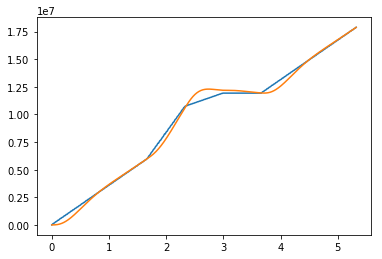

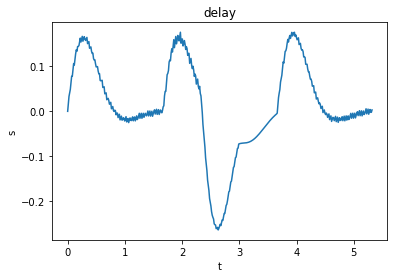

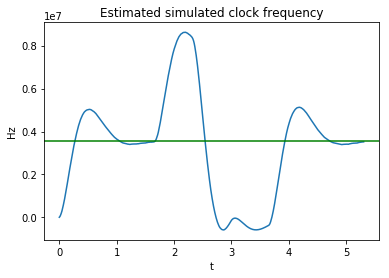

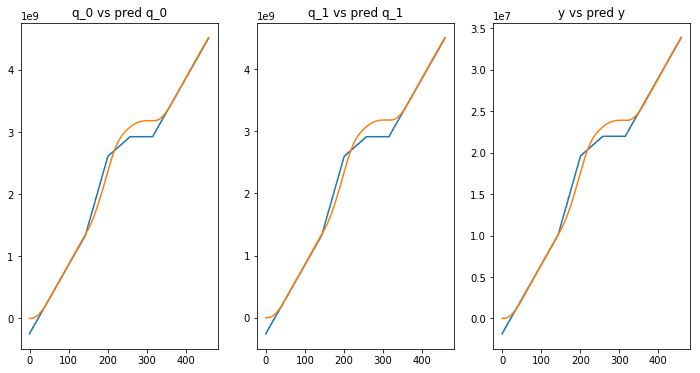

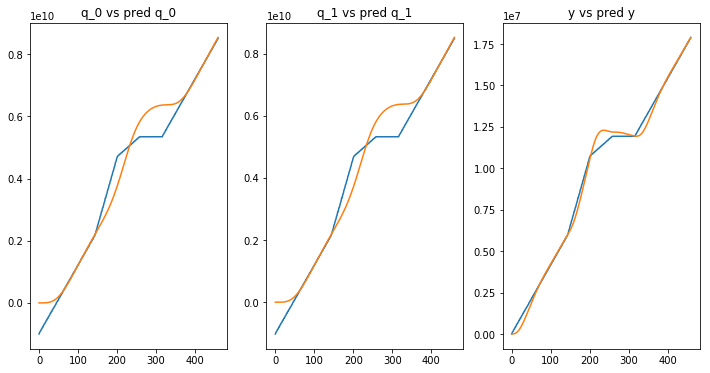

In [4]:
# Apply a second order section to a signal.
def apply_sos(sos, smoother, x):
  w = sos[3] * x - sos[4] * smoother[0] - sos[5] * smoother[1]
  y = sos[0] * w + sos[1] * smoother[0] + sos[2] * smoother[1]
  smoother = np.array([w, smoother[0]])
  return y, smoother

smoother = [np.array([0.,0.]) for _ in range(len(sos))]
smooth_c = np.zeros(c.shape)

# Bookkeeping for debugging.
saved = [[],[]]
temp = [0,0]

for i in range(len(t)):
    x = c[i]
    for k in range(len(smoother)):
        x, smoother[k] = apply_sos(sos[k,:], smoother[k], x)
        temp[k] = x
    smooth_c[i] = x

    # Test reinitialization formulas (but do not reinitialize)
    nominal_rate = Fcolor / Faudframe
    y = c[i]
    for k in range(len(smoother)):
        a = sos[k,3] / (1 + sos[k,4] + sos[k,5])
        b = (sos[k,5] - 1) / (1 + sos[k,4] + sos[k,5])
        p = sos[k,0] + sos[k,1] + sos[k,2]

        gamma = a*nominal_rate
        s0 = a*y + b*gamma
        s1 = a*y + b*gamma - gamma
        y = p*s0 + (sos[k,0] - sos[k,2])*gamma
        nominal_rate *= p*a

        saved[k].append(np.array([
            s0, smoother[k][0],
            s1, smoother[k][1],
            y, temp[k]
        ])[None,:])

plt.figure(1)
plt.plot(t, c)
plt.plot(t, smooth_c)

plt.figure(2)
plt.plot(t, (c - smooth_c) / Fcolor)
plt.ylabel('s')
plt.xlabel('t')
plt.title('delay')

plt.figure(3)
plt.plot(t[:-1], np.diff(smooth_c)*Faudframe)
plt.ylabel('Hz')
plt.xlabel('t')
plt.axhline(Fcolor, color='green')
plt.title('Estimated simulated clock frequency')

for k in range(2):
    x = np.concatenate(saved[k],0)
    fig = plt.figure(4+k,figsize=(12,6))
    fig.add_subplot(1,3,1)
    plt.plot(x[:,0])
    plt.plot(x[:,1])
    plt.title('q_0 vs pred q_0')

    fig.add_subplot(1,3,2)
    plt.plot(x[:,2])
    plt.plot(x[:,3])
    plt.title('q_1 vs pred q_1')

    fig.add_subplot(1,3,3)
    plt.plot(x[:,4])
    plt.plot(x[:,5])
    plt.title('y vs pred y')

print(f"Ideal clock {Fcolor}. Measured clock {(smooth_c[-1] - smooth_c[-2])*Faudframe}")

Now we test again, but this time with reinitialization:

Ideal clock 3579545.0. Measured clock 3559290.914617479


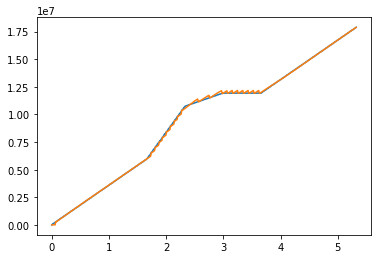

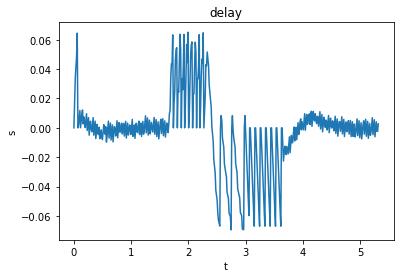

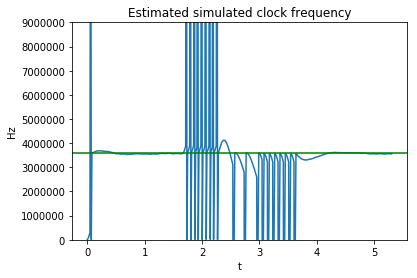

In [6]:
smoother = [np.array([0.,0.]) for _ in range(len(sos))]
smooth_c = np.zeros(c.shape)

for i in range(len(t)):
    x = c[i]
    for k in range(len(smoother)):
        x, smoother[k] = apply_sos(sos[k,:], smoother[k], x)
        smooth_c[i] = x
    
    # Reset if off by more than ten frames.
    if smooth_c[i] > c[i] + 5*3e6/60 or smooth_c[i] < c[i] - 5*3e6/60:
        nominal_rate = Fcolor / Faudframe
        y = c[i]
        for k in range(len(smoother)):
            a = sos[k,3] / (1 + sos[k,4] + sos[k,5])
            b = (sos[k,5] - 1) / (1 + sos[k,4] + sos[k,5])
            p = sos[k,0] + sos[k,1] + sos[k,2]
            gamma = a*nominal_rate
            s0 = a*y + b*gamma
            y = p*s0 + (sos[k,0] - sos[k,2])*gamma
            nominal_rate *= p*a
            smoother[k][0] = s0
            smoother[k][1] = s0 - gamma          

        smooth_c[i] = c[i]

plt.figure(1)
plt.plot(t, c)
plt.plot(t, smooth_c)

plt.figure(2)
plt.plot(t, (c - smooth_c) / Fcolor)
plt.ylabel('s')
plt.xlabel('t')
plt.title('delay')

plt.figure(3)
plt.plot(t[:-1], np.diff(smooth_c)*Faudframe)
plt.ylabel('Hz')
plt.xlabel('t')
plt.ylim(0, 3e6 * 3)
plt.axhline(Fcolor, color='green')
plt.title('Estimated simulated clock frequency')

print(f"Ideal clock {Fcolor}. Measured clock {(smooth_c[-1] - smooth_c[-2])*Faudframe}")